# Malaria Classification - Image Classification

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Preparing the data

In [2]:
dataset, dataset_set = tfds.load('malaria', split=['train'], as_supervised=True, shuffle_files=True, with_info=True)

In [3]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [4]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

In [5]:
DATASET_SIZE = len(dataset[0])

train_dataset = dataset[0].take(int(TRAIN_RATIO*DATASET_SIZE))

val_dataset = dataset[0].skip(int(TRAIN_RATIO*DATASET_SIZE)) # skips upto 80%
val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE)) # then takes the 10% of the remaining 20% as validation dataset

test_dataset = dataset[0].skip(int((TRAIN_RATIO+VAL_RATIO)*DATASET_SIZE)) # skips upto 90%
test_dataset = test_dataset.take(int(TEST_RATIO*DATASET_SIZE)) # then takes the 10% as test data

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2755


In [ ]:
print(list(train_dataset.take(1).as_numpy_iterator()))

## Visualising the Dataset

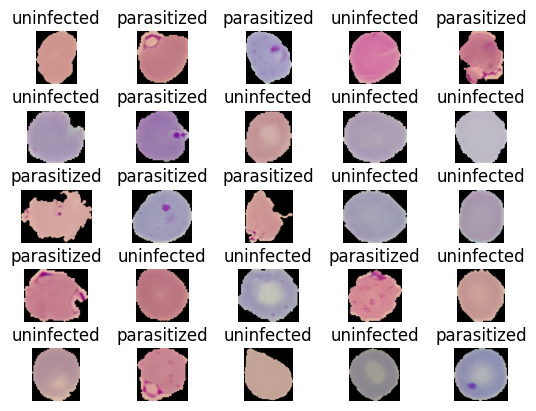

In [7]:
fig = plt.figure()

for i, (image, label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5, i+1)
  plt.imshow(image)
  plt.title(dataset_set.features['label'].int2str(label))
  plt.axis('off')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## Data Preprocessing

Normalisation
$$X = \frac{X - X(min)}{X(max) - X(min)}$$

i.e

$$
  X = \frac{X - 0}{255-0}\\
  X = \frac{X}{255}
$$



In [8]:
IMAGE_SIZE = 224

def resizing_rescaling(image, label):
  return tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255, label

In [9]:
train_dataset = train_dataset.map(resizing_rescaling)

In [10]:
test_dataset = test_dataset.map(resizing_rescaling)

In [11]:
val_dataset = val_dataset.map(resizing_rescaling)

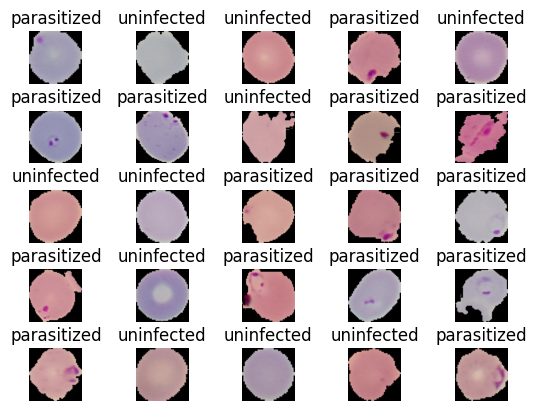

In [12]:
fig = plt.figure()

for i, (image, label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5, i+1)
  plt.imshow(image)
  plt.title(dataset_set.features['label'].int2str(label))
  plt.axis('off')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [13]:
BATCH_SIZE = 32

test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Convolutional Neural Network

In [14]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [15]:
# Partial Implementation of LeNet CNN

cnn = tf.keras.Sequential([
     InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE,3), batch_size=32),

     Conv2D(filters=6, kernel_size= 5, activation="relu"),
     BatchNormalization(),
     MaxPooling2D(pool_size=(2, 2), strides=2),

     Conv2D(filters=16, kernel_size= 5, activation="relu"),
     MaxPooling2D(pool_size=(2, 2), strides=2),
     BatchNormalization(),

     Flatten(),
     Dense(100, activation="relu"),
     BatchNormalization(),
     Dense(10, activation="relu"),
     BatchNormalization(),
     Dense(1, activation="sigmoid"),
])

print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 220, 220, 6)         456       
                                                                 
 batch_normalization (Batch  (32, 220, 220, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (32, 110, 110, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 106, 106, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 53, 53, 16)          0         
 g2D)                                                            
                                                        

In [16]:
cnn.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics='accuracy')

In [17]:
# history = cnn.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)
with tf.device('/gpu:0'):
  history = cnn.fit(train_dataset, validation_data=val_dataset,epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 50s 64ms/step - loss: 0.5045 - accuracy: 0.7420 - val_loss: 0.4463 - val_accuracy: 0.7593
Epoch 2/20
689/689 [==============================] - 52s 76ms/step - loss: 0.1996 - accuracy: 0.9334 - val_loss: 0.2497 - val_accuracy: 0.9368
Epoch 3/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1722 - accuracy: 0.9452 - val_loss: 0.8641 - val_accuracy: 0.6178
Epoch 4/20
689/689 [==============================] - 44s 63ms/step - loss: 0.1577 - accuracy: 0.9495 - val_loss: 0.2270 - val_accuracy: 0.9554
Epoch 5/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1735 - accuracy: 0.9409 - val_loss: 4.9578 - val_accuracy: 0.5158
Epoch 6/20
689/689 [==============================] - 43s 62ms/step - loss: 0.2059 - accuracy: 0.9313 - val_loss: 1.4987 - val_accuracy: 0.8439
Epoch 7/20
689/689 [==============================] - 50s 73ms/step - loss: 0.1886 - accuracy: 0.9323 - val_loss: 2.8092 - val_accuracy:

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
cd /content/drive/MyDrive/Deep-Learning/Malaria-Classification

/content/drive/MyDrive/Deep-Learning/Malaria-Classification


In [20]:
cnn.save_weights('malaria_checkpoints')

In [22]:
cnn.save('model/malaria-cnn.keras')

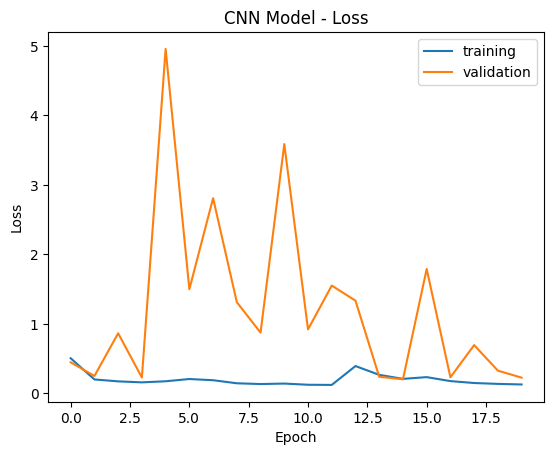

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

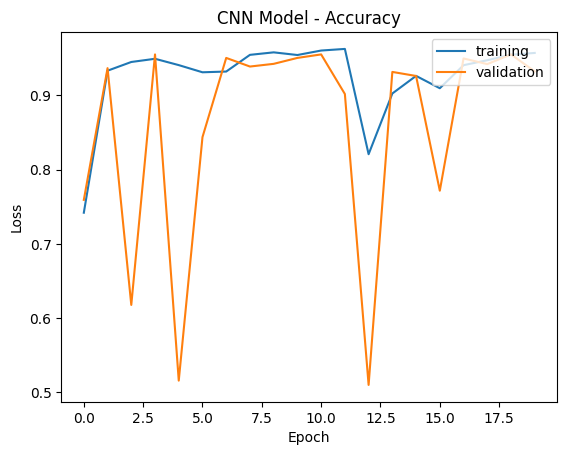

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [25]:
cnn.evaluate(test_dataset)

87/87 [==============================] - 14s 33ms/step - loss: 0.2751 - accuracy: 0.9183


[0.2750747501850128, 0.9183303117752075]

In [30]:
cnn.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.0012589901

In [39]:
THRESHOLD = 0.5

def parasite_or_not(predict_proba):
  """
    To check whether the given probability belong to parasite or uninfected cell

    Input:
      x: predicted probaility

    Returns
      (str): "Parasite" or "Uninfected"
  """
  if (predict_proba < THRESHOLD):
    return str("Parasite")
  return str("Uninfected")

1/1 [==============================] - 0s 31ms/step


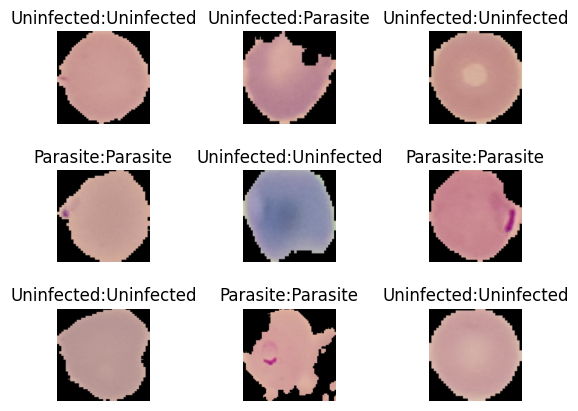

In [42]:
fig = plt.figure()

for i, (image, label) in enumerate(test_dataset.take(9)):
  plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) +":"+ str(parasite_or_not(cnn.predict(image)[0][0])))
  plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()